<a href="https://colab.research.google.com/github/YoonJeongHyun/web1/blob/master/%EC%BA%A1%EC%8A%A4%ED%86%A4_TimeSeries_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#################################################################
# 1. 라이브러리 임포트 (Libraries)
#################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import random

# 재현성을 위한 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [3]:
#################################################################
# 2. 데이터 로드 및 전처리 (Data Loading & Preprocessing)
#################################################################

def sliding_windows(data, seq_length):
    """
    슬라이딩 윈도우를 적용하여 시퀀스 데이터(X)와 타겟(y)을 생성합니다.
    """
    x = []
    y = []
    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)] # (seq_length, 1)
        _y = data[i + seq_length]     # (1,)
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)


def column_rename(df):
  col_map = {
    "건물번호": "building_no",
    "일시": "datetime",
    "기온(°C)": "temperature_C",
    "강수량(mm)": "precipitation_mm",
    "풍속(m/s)": "wind_speed_ms",
    "습도(%)": "humidity_percent",
    "일조(hr)": "sunshine_hours",
    "일사(MJ/m2)": "solar_radiation_MJ_m2",
    "전력소비량(kWh)": "power_consumption_kWh"
  }

  # 컬럼명 변경
  df = df.rename(columns=col_map)
  df['datetime'] = pd.to_datetime(df['datetime'], format="%Y%m%d %H")
  return df

def load_and_preprocess_data(file_path, target_column, seq_length, test_size_ratio=0.15, val_size_ratio=0.15, batch_size=32, EDA=False):
    """
    데이터를 로드하고, 정규화, 분할, 슬라이딩 윈도우 적용, DataLoader 생성을 수행합니다.
    """
    try:
        df = pd.read_csv(file_path)

    except FileNotFoundError:
        print(f"Error: {file_path} 파일을 찾을 수 없습니다.")
        # # 예시로 사용할 airline-passengers 데이터를 다운로드합니다.
        # print("예시로 airline-passengers.csv 데이터를 다운로드합니다.")
        # !wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
        # file_path = 'airline-passengers.csv'
        # target_column = 'Passengers'
        # df = pd.read_csv(file_path)

    df = column_rename(df)
    if EDA:
      return df

    try:
        training_set_raw = df[target_column].values.astype(float)
        training_set_raw = training_set_raw.reshape(-1, 1)
    except KeyError:
        print(f"Error: '{target_column}' 열을 찾을 수 없습니다. 열 이름을 확인해주세요.")
        return None, None, None, None

    # 데이터 분할 (Train / Validation / Test)
    total_size = len(training_set_raw)
    test_size = int(total_size * test_size_ratio)
    val_size = int(total_size * val_size_ratio)
    train_size = total_size - test_size - val_size

    train_data_raw = training_set_raw[0:train_size]
    val_data_raw = training_set_raw[train_size - seq_length : train_size + val_size] # train_data의 마지막 seq_length 포함
    test_data_raw = training_set_raw[train_size + val_size - seq_length :] # val_data의 마지막 seq_length 포함

    # 정규화 (Scaler)
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data_raw)
    val_data = sc.transform(val_data_raw)
    test_data = sc.transform(test_data_raw)

    # 슬라이딩 윈도우 적용
    x_train, y_train = sliding_windows(train_data, seq_length)
    x_val, y_val = sliding_windows(val_data, seq_length)
    x_test, y_test = sliding_windows(test_data, seq_length)

    # print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
    # print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
    # print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

    # Tensor로 변환
    trainX = torch.Tensor(np.array(x_train))
    trainY = torch.Tensor(np.array(y_train))
    valX = torch.Tensor(np.array(x_val))
    valY = torch.Tensor(np.array(y_val))
    testX = torch.Tensor(np.array(x_test))
    testY = torch.Tensor(np.array(y_test))

    # DataLoader 생성
    train_dataset = TensorDataset(trainX, trainY)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(valX, valY)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = TensorDataset(testX, testY)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Data Loaded: Train({len(x_train)}), Validation({len(x_val)}), Test({len(x_test)})")

    return train_loader, val_loader, test_loader, sc


In [4]:


#################################################################
# 3. 모델 정의 (Model Definitions)
#################################################################

# --- 모델 1: Linear Regression ---
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(LinearModel, self).__init__()
        self.input_dim = input_dim
        # 입력 차원을 [batch, seq_len, 1] -> [batch, seq_len]로 가정
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # x shape: [batch_size, seq_length, features=1]
        # 모델이 [batch, seq_len]을 기대하므로 squeeze
        x = x.squeeze(-1)
        out = self.linear(x)
        return out.unsqueeze(-1) # [batch_size, 1] -> [batch_size, 1, 1] (y와 차원 맞춤)

# --- 모델 2: MLP (Multi-Layer Perceptron) ---
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(MLPModel, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: [batch_size, seq_length, features=1]
        x = x.squeeze(-1) # [batch_size, seq_length]
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out.unsqueeze(-1) # [batch_size, 1, 1]

# --- 모델 3: Transformer (PatchTST 기반) ---
class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        d_h = d_model // n_heads
        self.scale = d_h**-0.5
        self.n_heads, self.d_h = n_heads, d_h
        self.W_Q = nn.Linear(d_model, d_h * n_heads)
        self.W_K = nn.Linear(d_model, d_h * n_heads)
        self.W_V = nn.Linear(d_model, d_h * n_heads)
        self.to_out = nn.Linear(n_heads * d_h, d_model)

    def forward(self, q, k, v):
        bs = q.size(0)
        q_s = self.W_Q(q).view(bs, -1, self.n_heads, self.d_h)
        k_s = self.W_K(k).view(bs, -1, self.n_heads, self.d_h)
        v_s = self.W_V(v).view(bs, -1, self.n_heads, self.d_h)
        attn_scores = torch.einsum('bphd, bshd -> bphs', q_s, k_s) * self.scale
        attn_weights = F.softmax(attn_scores, dim=-1)
        output = torch.einsum('bphs, bshd -> bphd', attn_weights, v_s)
        output = output.contiguous().view(bs, -1, self.n_heads*self.d_h)
        output = self.to_out(output)
        return output

class EncoderBlock(nn.Module):
    def __init__(self, input_dim):
        super(EncoderBlock, self).__init__()
        self.input_dim = input_dim
        self.ffn = nn.Sequential(nn.Linear(self.input_dim, 2*self.input_dim),
                        nn.GELU(),
                        nn.Dropout(0.2),
                        nn.Linear(2*self.input_dim, self.input_dim))
        self.layernorm = nn.LayerNorm(self.input_dim)
        self.dropout = nn.Dropout(0.2)
        self.attn = AttentionBlock(self.input_dim, 2)

    def forward(self, x):
        y = self.attn(x,x,x)
        x = x + self.dropout(y)
        x = self.layernorm(x)
        y = self.ffn(x)
        x = x + self.dropout(y)
        y = self.layernorm(x)
        return y

class TransformerModel(nn.Module):
    # 원본 코드의 Transformer 클래스
    # input_dim은 seq_length를 의미합니다.
    def __init__(self, input_dim, emb_dim, out_dim, num_encoder):
        super().__init__()
        self.input_dim = input_dim # seq_length
        self.emb_dim = emb_dim
        # 원본 코드는 seq_len을 2로 나누어 처리 (reshape(-1, 2, input_dim//2))
        # 이 로직을 따르기 위해 input_layer의 입력 차원을 emb_dim//2로 설정
        # (원래 코드에서 input_dim//2 였습니다)
        self.input_layer = nn.Linear(input_dim//2, emb_dim//2, bias=True)
        self.encoder_layers = nn.ModuleList([])
        for i in range(num_encoder):
            self.encoder_layers.append(EncoderBlock(emb_dim//2))
        self.flatten = nn.Flatten()
        self.output_layer = nn.Linear(emb_dim, out_dim, bias=True)

    def forward(self, x):
        # x: [batch_size, seq_length, 1]
        x = x.squeeze(-1) # [batch_size, seq_length]

        # 원본 코드의 정규화 로직 (모델 내부에서)
        mean = x.mean(dim=1,keepdim=True)
        std = x.std(dim=1,keepdim=True) + 1e-6 # 0으로 나누는 것을 방지
        x = (x-mean)/std

        # 원본 코드의 Reshape 로직 (seq_length=4 -> (2, 2))
        # seq_length가 짝수여야 함
        try:
            x = x.reshape(-1, 2, self.input_dim//2)
        except RuntimeError as e:
            print(f"Error: TransformerModel의 Reshape에 실패했습니다. seq_length({self.input_dim})가 짝수인지 확인하세요.")
            print(f"입력 x shape: {x.shape}")
            raise e

        x = self.input_layer(x) # [batch, 2, emb_dim//2]
        for l in self.encoder_layers:
            x = l(x)
        x = self.flatten(x) # [batch, 2 * (emb_dim//2)] = [batch, emb_dim]
        x = self.output_layer(x) # [batch, 1]

        # 정규화 역변환
        x = x*std+mean
        return x.unsqueeze(-1) # [batch, 1, 1]







In [5]:
#################################################################
# 4. 학습 및 검증 루프 (Training & Validation Loop)
#################################################################

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, model_save_path='best_model.pth'):

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train() # 학습 모드
        train_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # 모델 포워딩 (모델 입력은 [batch, seq_len, 1]을 가정)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 검증 (Validation)
        model.eval() # 평가 모드
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}')

        # 최고 성능 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            # print(f'New best model saved! Val Loss: {best_val_loss:.5f}')

    print(f"Training finished. Best validation loss: {best_val_loss:.5f}")
    print(f"Best model saved to {model_save_path}")


In [6]:
#################################################################
# 5. 메인 실행 (Main Execution)
#################################################################

# --- Hyperparameters & Configuration ---
FILE_PATH = 'train.csv'  # <-- (1) 여기에 파일 경로를 입력하세요.
# FILE_PATH = 'airline-passengers.csv'  # <-- (1) 여기에 파일 경로를 입력하세요.
TARGET_COLUMN_NAME = 'power_consumption_kWh'     # <-- (2) 여기에 예측할 열 이름을 입력하세요.
MODEL_NAME = 'TRANSFORMER'            # <-- (3) 'LINEAR', 'MLP', 'TRANSFORMER' 중 선택

SEQ_LENGTH = 12       # 시퀀스 길이 (Transformer는 짝수 권장)
BATCH_SIZE = 32
NUM_EPOCHS = 2000     # Epoch 횟수
LEARNING_RATE = 0.0001
TEST_RATIO = 0.15
VAL_RATIO = 0.15
BEST_MODEL_PATH = 'best_model.pth'

# --- 모델별 하이퍼파라미터 ---
MLP_HIDDEN_DIM = 64
TRANSFORMER_EMBED_DIM = 32  # 원본 코드 16 (emb_dim)
TRANSFORMER_ENCODER_LAYERS = 3 # 원본 코드 3 (num_layers)
# -----------------------------------

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [10]:
df = load_and_preprocess_data(
    FILE_PATH, TARGET_COLUMN_NAME, SEQ_LENGTH, TEST_RATIO, VAL_RATIO, BATCH_SIZE
, EDA=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   num_date_time          204000 non-null  object        
 1   building_no            204000 non-null  int64         
 2   datetime               204000 non-null  datetime64[ns]
 3   temperature_C          204000 non-null  float64       
 4   precipitation_mm       204000 non-null  float64       
 5   wind_speed_ms          204000 non-null  float64       
 6   humidity_percent       204000 non-null  float64       
 7   sunshine_hours         204000 non-null  float64       
 8   solar_radiation_MJ_m2  204000 non-null  float64       
 9   power_consumption_kWh  204000 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 15.6+ MB


In [12]:
df_sample = df.query('building_no == 1')
df_sample = df_sample.set_index('datetime')

In [13]:
df_y = df_sample[['power_consumption_kWh']].copy()
# df_y = df_y.asfreq('w')  # 시간당 예시
# # 간단 보간
df_y['y_lin'] = df_y['power_consumption_kWh'].interpolate(method='time')
# # 표준화 예시
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_y['y_z'] = scaler.fit_transform(df_y[['y_lin']])


In [14]:
q1, q3 = df_y['y_lin'].quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
df_y['is_outlier_iqr'] = (df_y['y_lin'] < lo) | (df_y['y_lin'] > hi)

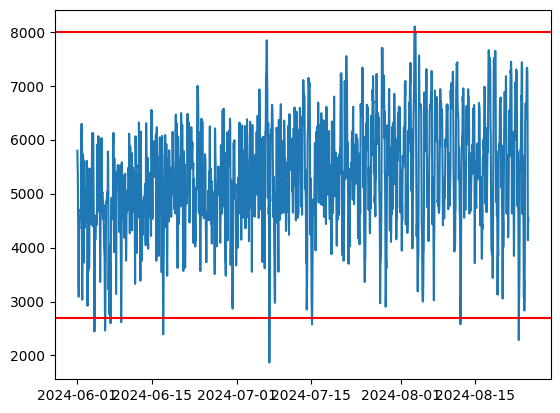

In [16]:
plt.plot(df_y.index, df_y['power_consumption_kWh'])
plt.axhline(y=lo,color='r')
plt.axhline(y=hi,color='r')
plt.show()

In [17]:
# 이동통계 기반
win = 24
roll_mean = df_y['y_lin'].rolling(win, min_periods=win//2).mean()
roll_std  = df_y['y_lin'].rolling(win, min_periods=win//2).std()
z = (df_y['y_lin'] - roll_mean) / roll_std
df_y['is_outlier_z'] = z.abs() > 3

In [19]:
df_y[df_y['is_outlier_z'] == True]

,power_consumption_kWh,y_lin,is_outlier_iqr,is_outlier_z
datetime,,,,
2024-06-04 05:00:00,2445.78,2445.78,True,True


In [48]:
df_y[df_y['is_outlier_iqr'] == True]

,power_consumption_kWh,y_lin,is_outlier_iqr
datetime,,,
2024-06-04 05:00:00,2445.78,2445.78,True
2024-06-04 06:00:00,2652.30,2652.30,True
2024-06-06 05:00:00,2462.97,2462.97,True
2024-06-06 06:00:00,2522.88,2522.88,True
2024-06-07 06:00:00,2598.51,2598.51,True
2024-06-09 06:00:00,2617.47,2617.47,True
2024-06-17 04:00:00,2393.88,2393.88,True
2024-07-07 04:00:00,1870.44,1870.44,True
2024-07-15 05:00:00,2577.78,2577.78,True


       power_consumption_kWh        y_lin
count            2040.000000  2040.000000
mean             5340.317485  5340.317485
std               983.430077   983.430077
min              1870.440000  1870.440000
25%              4679.160000  4679.160000
50%              5326.050000  5326.050000
75%              6005.827500  6005.827500
max              8097.240000  8097.240000


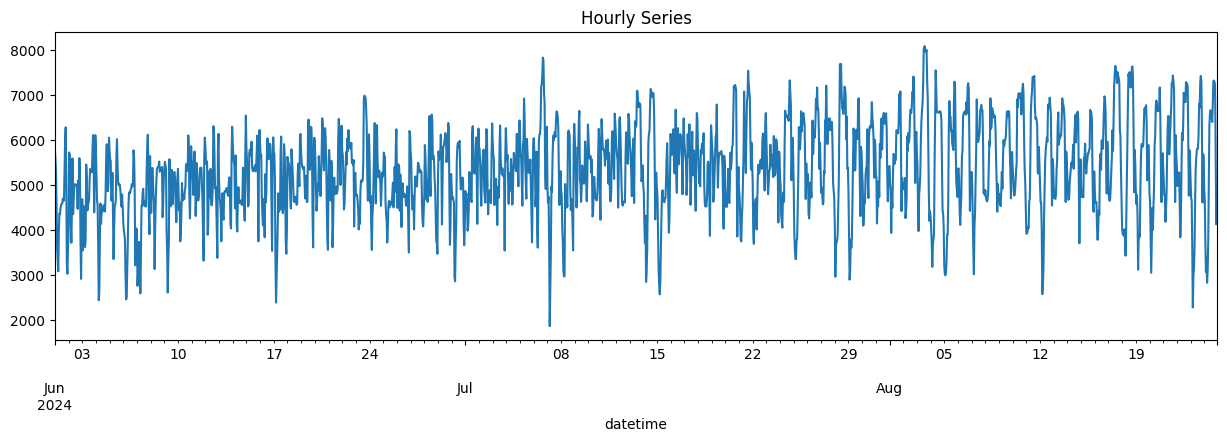

In [24]:
df_y['power_consumption_kWh'].plot(figsize=(15,4), title='Hourly Series')

# 요약 통계
print(df_y.describe())

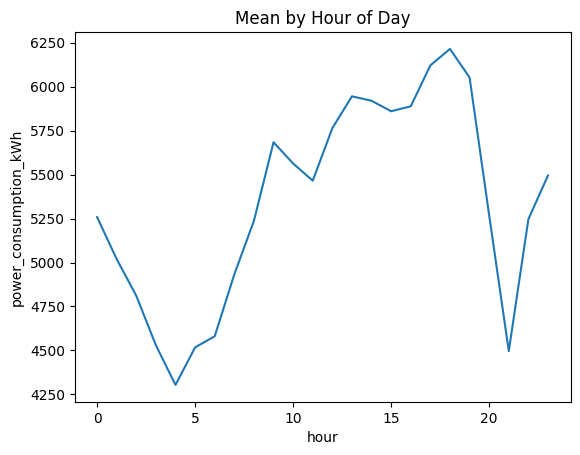

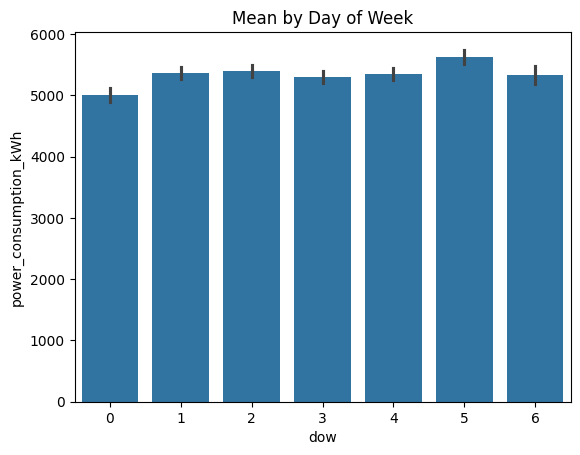

In [25]:
import seaborn as sns
df_y['hour'] = df_y.index.hour
df_y['dow'] = df_y.index.dayofweek  # 0=월

# 시간대별 평균
sns.lineplot(x='hour', y='power_consumption_kWh', data=df_y, estimator='mean', errorbar=None)
plt.title('Mean by Hour of Day'); plt.show()

# 요일별 평균
sns.barplot(x='dow', y='power_consumption_kWh', data=df_y, estimator='mean')
plt.title('Mean by Day of Week'); plt.show()

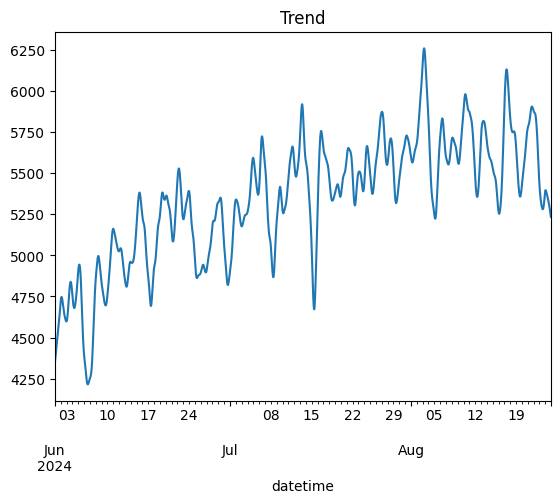

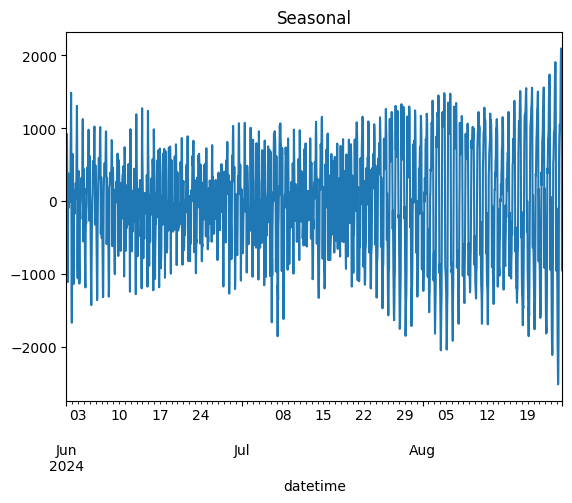

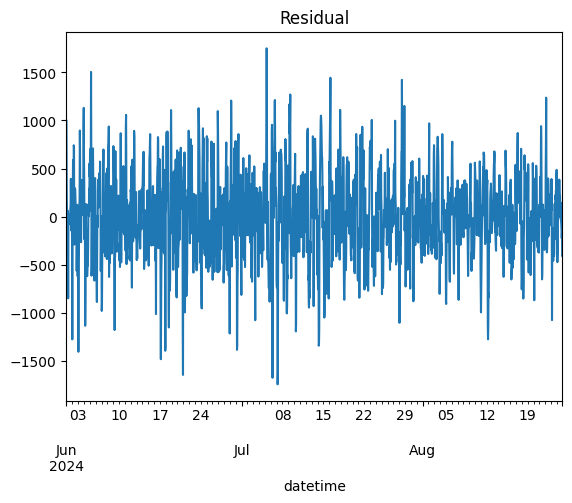

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

series = df_y['y_lin'].dropna()
stl = STL(series, period=24)  # 일중 계절 예시
res = stl.fit()

plt.figure()
res.trend.plot(title='Trend'); plt.show()

plt.figure()
res.seasonal.plot(title='Seasonal'); plt.show()

plt.figure()
res.resid.plot(title='Residual'); plt.show()

In [21]:

# 1. 데이터 로드
train_loader, val_loader, test_loader, scaler = load_and_preprocess_data(
    FILE_PATH, TARGET_COLUMN_NAME, SEQ_LENGTH, TEST_RATIO, VAL_RATIO, BATCH_SIZE
)

# 2. 모델 선택 및 초기화
if MODEL_NAME == 'LINEAR':
    model = LinearModel(input_dim=SEQ_LENGTH, output_dim=1)
    print("Model: Linear Regression")
elif MODEL_NAME == 'MLP':
    model = MLPModel(input_dim=SEQ_LENGTH, hidden_dim=MLP_HIDDEN_DIM, output_dim=1)
    print(f"Model: MLP (Hidden dim: {MLP_HIDDEN_DIM})")
elif MODEL_NAME == 'TRANSFORMER':
    if SEQ_LENGTH % 2 != 0:
        print(f"Warning: Transformer 모델은 seq_length가 짝수일 때 가장 잘 작동합니다. 현재: {SEQ_LENGTH}")
    model = TransformerModel(input_dim=SEQ_LENGTH,
                               emb_dim=TRANSFORMER_EMBED_DIM,
                               out_dim=1,
                               num_encoder=TRANSFORMER_ENCODER_LAYERS)
    print(f"Model: Transformer (Embed dim: {TRANSFORMER_EMBED_DIM}, Layers: {TRANSFORMER_ENCODER_LAYERS})")
else:
    raise ValueError("MODEL_NAME을 'LINEAR', 'MLP', 'TRANSFORMER' 중에서 선택해주세요.")

model.to(device)

# 3. 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. 모델 학습
train_model(model, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS, device, BEST_MODEL_PATH)

Data Loaded: Train(142788), Validation(30600), Test(30600)
Model: Transformer (Embed dim: 32, Layers: 3)


KeyboardInterrupt: 


--- Testing ---
Test Loss (MSE): 1.33019


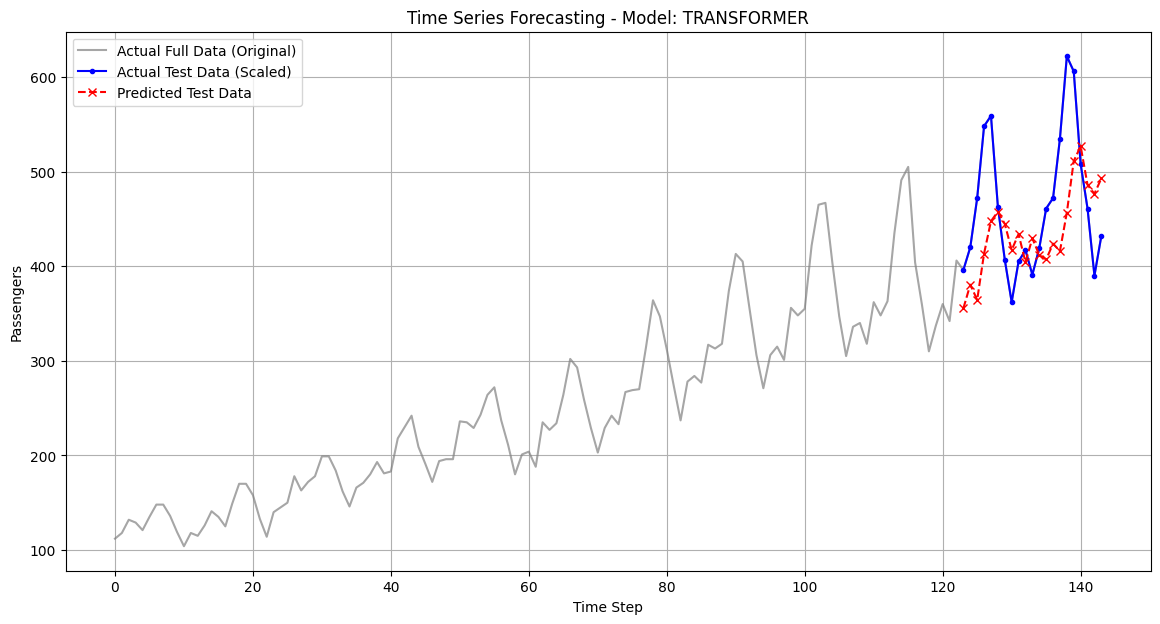

In [10]:


#################################################################
# 6. 테스트 및 결과 시각화 (Testing & Visualization)
#################################################################

print("\n--- Testing ---")
# 저장된 최고 성능 모델 로드
if MODEL_NAME == 'LINEAR':
    best_model = LinearModel(input_dim=SEQ_LENGTH, output_dim=1)
elif MODEL_NAME == 'MLP':
    best_model = MLPModel(input_dim=SEQ_LENGTH, hidden_dim=MLP_HIDDEN_DIM, output_dim=1)
elif MODEL_NAME == 'TRANSFORMER':
    best_model = TransformerModel(input_dim=SEQ_LENGTH,
                                    emb_dim=TRANSFORMER_EMBED_DIM,
                                    out_dim=1,
                                    num_encoder=TRANSFORMER_ENCODER_LAYERS)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH))
best_model.to(device)
best_model.eval()

test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss (MSE): {avg_test_loss:.5f}')

# 예측 결과 및 실제 값 취합
predictions_np = np.concatenate(all_predictions).reshape(-1, 1)
targets_np = np.concatenate(all_targets).reshape(-1, 1)

# 정규화 역변환 (Inverse Transform)
predictions_scaled = scaler.inverse_transform(predictions_np)
targets_scaled = scaler.inverse_transform(targets_np)

# 테스트셋의 실제 Y값 (전체 데이터 기준 인덱스)
df = pd.read_csv(FILE_PATH)
full_data = df[TARGET_COLUMN_NAME].values.astype(float)
test_start_index = len(full_data) - len(targets_scaled)

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(full_data, label='Actual Full Data (Original)', color='gray', alpha=0.7)
plt.plot(range(test_start_index, test_start_index + len(targets_scaled)), targets_scaled, label='Actual Test Data (Scaled)', color='blue', marker='.')
plt.plot(range(test_start_index, test_start_index + len(predictions_scaled)), predictions_scaled, label='Predicted Test Data', color='red', linestyle='--', marker='x')

plt.title(f'Time Series Forecasting - Model: {MODEL_NAME}')
plt.xlabel('Time Step')
plt.ylabel(TARGET_COLUMN_NAME)
plt.legend()
plt.grid(True)
plt.show()

In [13]:
predictions_scaled

array([[355.51273],
       [380.49246],
       [364.47464],
       [413.44254],
       [447.6311 ],
       [457.6675 ],
       [444.82056],
       [417.0494 ],
       [433.99908],
       [404.28632],
       [429.47128],
       [411.8805 ],
       [407.10876],
       [423.87592],
       [416.04028],
       [456.74292],
       [511.1664 ],
       [526.8668 ],
       [486.015  ],
       [476.54974],
       [492.87314]], dtype=float32)